In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import regnet_y_400mf

In [ ]:
model = regnet_y_400mf(pretrained=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Modification de la dernière couche pour 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes de CIFAR-10
model = model.to(device)

C:\Users\klieske\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\klieske\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # taille pour RegNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

loss_values = []
accuracy_values = []

def adjust_learning_rate(optimizer, epoch):
    lr = 0.01 if epoch >= 8 else 0.1  # Diminution du LR après 80 époques
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Entraînement
for epoch in range(num_epochs):
    model.train()
    adjust_learning_rate(optimizer, epoch)
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    loss_values.append(running_loss / len(trainloader))
    accuracy_values.append(accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy:.2f}%, Loss: {running_loss/len(trainloader):.4f}, Lr: {current_lr:.6f}")



Epoch 1/10, Accuracy: 24.50%, Loss: 2.2074, Lr: 0.100000
Epoch 2/10, Accuracy: 41.29%, Loss: 1.6128, Lr: 0.100000
Epoch 3/10, Accuracy: 50.56%, Loss: 1.3713, Lr: 0.100000
Epoch 4/10, Accuracy: 58.29%, Loss: 1.1753, Lr: 0.100000
Epoch 5/10, Accuracy: 63.87%, Loss: 1.0142, Lr: 0.100000
Epoch 6/10, Accuracy: 68.67%, Loss: 0.8874, Lr: 0.100000
Epoch 7/10, Accuracy: 72.69%, Loss: 0.7753, Lr: 0.100000
Epoch 8/10, Accuracy: 75.86%, Loss: 0.6832, Lr: 0.100000
Epoch 9/10, Accuracy: 85.69%, Loss: 0.4196, Lr: 0.010000
Epoch 10/10, Accuracy: 88.64%, Loss: 0.3333, Lr: 0.010000


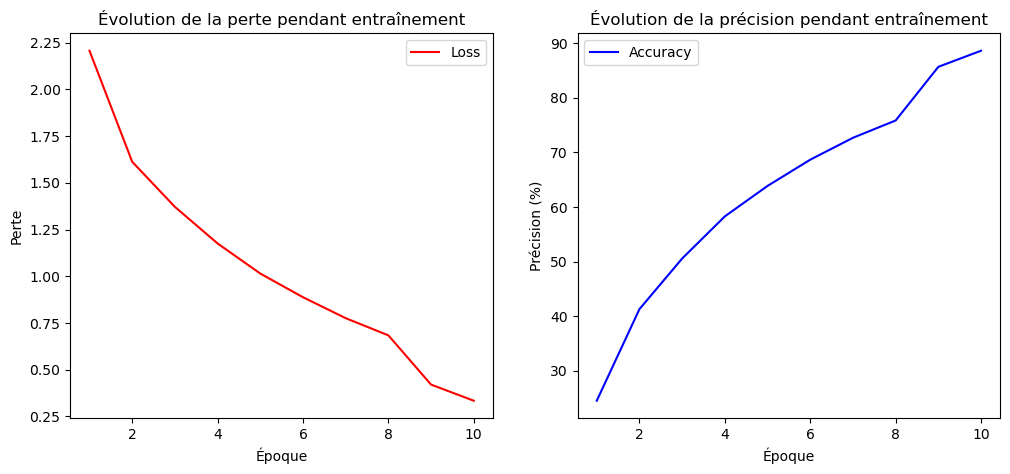

In [ ]:
# Tracé du graphe Erreur
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_values, label='Loss', color='red')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Évolution de la perte pendant entraînement')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracy_values, label='Accuracy', color='blue')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.title('Évolution de la précision pendant entraînement')
plt.legend()

plt.show()

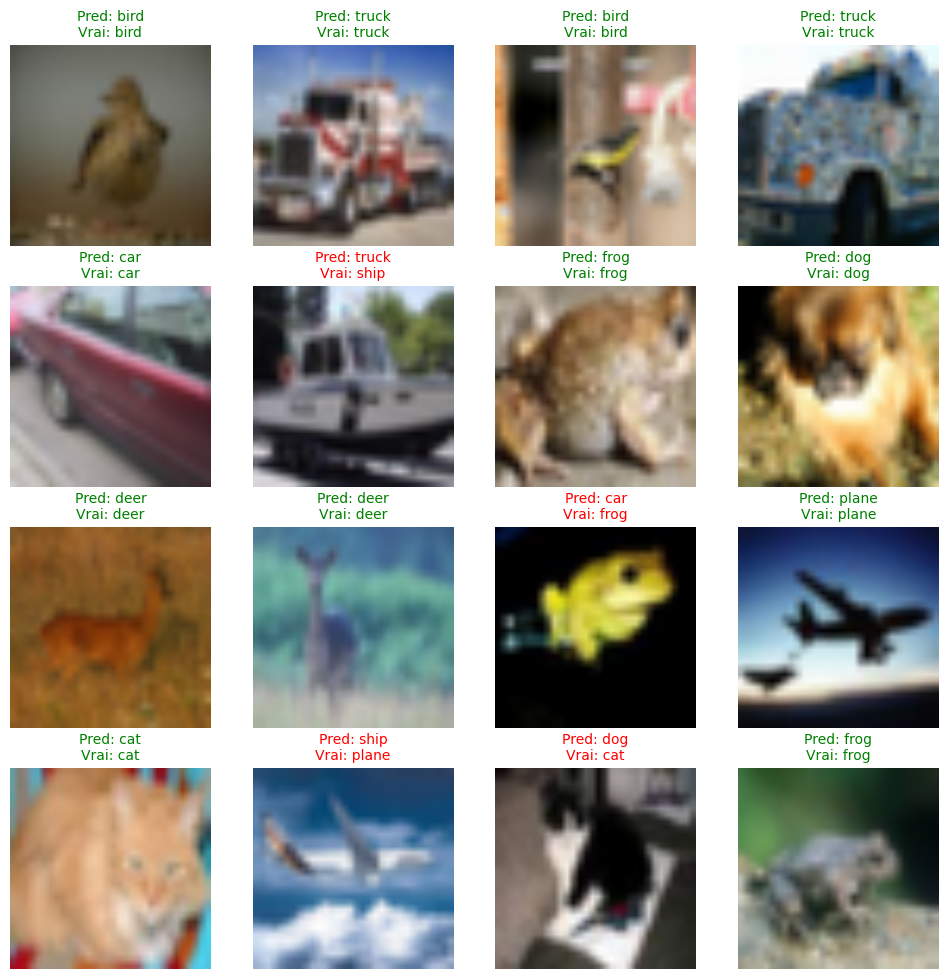

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

all_images = []
all_labels = []
for images, labels in testloader:
    all_images.append(images)
    all_labels.append(labels)
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)
random_indices = random.sample(range(len(all_images)), 16)
random_images = all_images[random_indices].to(device)
random_labels = all_labels[random_indices].to(device)
outputs = model(random_images)
_, predicted = torch.max(outputs, 1)
random_images = random_images.cpu()
predicted = predicted.cpu()
random_labels = random_labels.cpu()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    title = f"Pred: {classes[predicted[i]]}\nVrai: {classes[random_labels[i]]}"
    ax.imshow(np.transpose((random_images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    ax.set_title(title, fontsize=10, color='green' if predicted[i] == random_labels[i] else 'red')
    ax.axis('off')
plt.show()

In [ ]:
torch.save(model.state_dict(), "./model_RegNet_400mf_10_epochs.pth")
print("Saved model to disk.")

Saved model to disk.
